# How to run this file?
In this file, there are three cells: 'define functions', 'simulation', 'graphing' cell. 
- First, run the 'define functions' cell to define functions.
- After you run 'define functions' cell, you will see 'config parameters' section explains the parameters you can change in the next cell ('simulation' cell).
- After you modify parameters, run the 'simulation' cell. You will see '-------Simulation Start----------',..., until'----------Simulation Finished---------', meaning simulation completed. The processing time depends on the game length you select.
- Finally, run the 'graphing' cell. The result shows dynamics graphs over periods. The top left graph shows payoffs for each strategies over periods and green triangle shows which player gets the chance to move; The top right graph shows cdf; the bottom graph shows strategies over periods. 

In [1]:
#########################################################
########## run this cell to define functions ############
############### 'define functions' cell #################
#########################################################


########## configuration ############
import math

def sim_config_init(game_type= 'fear', lgr=(10,1.1,0.5), sampling=None, purification=None,
                    trembling=0., theta=None, bandwidth=None, asynchronous=True,
                    num_bots=20, game_length=1000,
                    ):
    '''
    Specify simulation configuration parameters
    :param game_type: string, game type
    :param lgr: tuple, (lambda, gamma, rho), default to (10,1.1,0.5)
    :param sampling: int, number of players to sample (give each player an array of random other players to sample), default to None
    :param purification: idiosyncratic shifts of perceived landscape
    :param trembling: float, trembling range, default to 0, trembles in jump destination
    :param theta: float, constant for calculating player move chance, default to 0.2
    :param bandwidth: float, smoothing bandwidth, default to None
    :param asynchronous: boolean, game synchronicity, False means all players decide their moves based on the previous tick, True means players see moves as they happen, default to False
    :param num_bots: int, number of bots, default to 20
    :param game_length: int, game length, default to 1000
    :return: config, dictionary containing all simulation configuration parameters
    '''

    config = {}

    # set to -1 to disable
    config['sampling'] = sampling

    # constant e in purification specs
    # set to -1 to disable
    config['purification'] = purification

    # trembling range
    # set to 0 to have no effect
    config['trembling'] = trembling

    # constant for calculating player move chance
    config['theta'] = theta

    # smoothing bandwidth
    # set to -1 to disable
    config['bandwidth'] = bandwidth

    # game type
    config['game_type'] = game_type

    # lambda/gamma/rho params
    config['lambda'] = lgr[0]
    config['gamma'] = lgr[1]
    config['rho'] = lgr[2]

    # based on gamma and rho, override game type
    if config['gamma'] >= (config['rho'] + 4/3):
        config['game_type'] = 'greed'
    elif config['gamma'] <= (config['rho'] + 2/3):
        config['game_type'] = 'fear'

    # rush range (MUST BE CORRECT IF STARTING AT CDF)
    if config['game_type'] == 'fear':
        config['cdfmin'] = max(0, round((config['lambda'] - math.sqrt(1+config['lambda']**2) * math.sqrt(1-(16*(1+config['rho'])*(config['gamma']-1))/((config['gamma'] +3*config['rho'])*(3*config['gamma'] +config['rho'])))),2))
        config['cdfmax'] = config['lambda']
    elif config['game_type'] == 'greed':
        config['cdfmin'] = config['lambda']
        config['cdfmax'] = config['lambda'] + math.sqrt(1+config['lambda']**2)/(math.sqrt(1+16*config['rho']*config['gamma']/((3*config['gamma']-3*config['rho']-2)*(config['gamma']-config['rho']+2))))

    # game synchronicity
    # False means all players decide their moves based on the previous tick
    # True means players see moves as they happen
    config['asynchronous'] = asynchronous

    # number of bots
    config['num_bots'] = num_bots

    # game length
    config['game_length'] = game_length

    # x bound
    config['xmin'] = max(0 , config['cdfmin']-2)
    config['xmax'] = config['cdfmax'] + 3

    return config


########## functions ############

# Returns the position in group for a given timing n (for a given n, how many strategies are less than n)
# optional parameter seed denotes which set of players to sample (-1 for no sampling)
def get_position(n, seed, strats, sample_sets, config):
    '''

    :param n: float, timing n
    :param seed: index of player i, default to none
    :param strats: array, current strategies
    :param sample_sets: ndarray, sample sets (None if sampling is none), give each player an array of random other players to sample
    :param config: dict, dictionary containing simulation parameters
    :return: float, position for timing n
    '''
    # positions are approximated more accurately by adding 0 to the value for greed and 1 for fear game
    if config['game_type'] == 'fear':
        pos = 1
    elif config['game_type'] == 'greed':
        pos = 0
    samples = []
    # if using sampling, get the strategies of the sampled players
    if (seed is not None) and (config['sampling'] is not None):
        for samp in sample_sets[seed]:
            samples.append(strats[samp])
    # otherwise check all strategies
    else:
        samples = strats
    # compare to strategies to calculate position
    for strat in samples:
        if n > strat:
            pos = pos + 1
    return pos

# Returns ties at timing n
# optional parameter seed denotes which set of players to sample (-1 for no sampling)
def get_tie(n, seed, strats, sample_sets, config):
    '''

    :param n: float, timing n
    :param seed: index of player i, default to none
    :param strats: array, current strategies
    :param sample_sets: ndarray, sample sets (None if sampling is none), give each player an array of random other players to sample
    :param config: dict, dictionary containing simulation parameters
    :return: float, ties for timing n
    '''
    # this is only here to fix rounding comparison issues
    n = round(n,2)

    tie = 0
    samples = []
    # if using sampling, get the strategies of the sampled players
    if (seed is not None) and (config['sampling'] is not None):
        for samp in sample_sets[seed]:
            samples.append(strats[samp])
    # otherwise check all strategies
    else:
        samples = strats
    # compare to strategies to calculate position
    for strat in samples:
        # more rounding stuff due to float precision errors
        strat = round(strat, 2)
        if n == strat:
            tie = tie + 1
    return tie


# Returns the payoff at timing n
def get_y(n, strats, sample_sets, config, seed=None, use_bandwidth=False):
    '''

    :param n: float, timing n
    :param strats: array, current strategies
    :param sample_sets: ndarray, sample sets (None if sampling is none), give each player an array of random other players to sample
    :param config: dict, dictionary containing simulation parameters
    :param seed: index of player i, default to none
    :param use_bandwidth:
    :return: float, payoff
    '''
    # calculate the timing component
    ux = 1 + (2 * config['lambda'] * n) - (n * n)
    ties = get_tie(n, seed, strats, sample_sets, config)
    pos = get_position(n, seed, strats, sample_sets, config)
    if (seed is not None) and (config['purification'] is not None):
        puriVal = 1 - (config['purification'] * seed/len(strats))
    else:
        puriVal = 1
    vy = (1 - (pos * puriVal/len(strats))/config['gamma']) * (1 + (pos * puriVal/len(strats)/config['rho']))
    # if there are ties, calculate the average of the position components over the tie range
    if ties > 0:
        vy = 0
        for j in range(ties):
            vy += (1 - ((pos+j) * puriVal/len(strats))/config['gamma']) * (1 + ((pos+j) * puriVal/len(strats))/config['rho'])
        vy = vy/ties
    # otherwise just use the regular formula
    if (config['bandwidth'] is not None) and use_bandwidth:
        ux = 0
        start_x = n - config['bandwidth']
        for i in range(21):
            ux += 1 + (2 * config['lambda'] * start_x) - (start_x * start_x)
            start_x += config['bandwidth']/10
        # ties = get_tie(n, seed, strats, sample_sets, config)
        # pos = get_position(n, seed, strats, sample_sets, config)
        # vy = (1 - (pos * puriVal/len(strats))/config['gamma']) * (1 + (pos * puriVal/len(strats)/config['rho']))
        # # if there are ties, calculate the average of the position components over the tie range
        # if ties > 0:
        #     vy1 = 0
        #     for j in range(ties):
        #         vy1 += (1 - ((pos+j) * puriVal/len(strats))/config['gamma']) * (1 + ((pos+j) * puriVal/len(strats))/config['rho'])
        #     vy1 = vy/ties
        ux = ux/21
    return ux * vy


def data_logging(var_name_list, round_num, history):
    for var in var_name_list:
        history[var, round_num] = eval({var})

    return history


########## simulation functions ############
import random
import numpy as np
# from timing_games_package import Functions as fun

def initialize_player_strategies(config):
    '''
    Function to run first simulation step to initialize each player's initial strategy
    :param config: dict, dictionary contains simulation parameters
    :return: array, initial strategies;  ndarray, sample sets (None if sampling is none), give each player an array of random other players to sample
    '''
    # game type for starting distribution: set to fear or greed for respective distributions
    # any value other than fear or greed will yield a random start
    game = config['game_type']
    num_bots = config['num_bots']
    lam = config['lambda']
    gam = config['gamma']
    rho = config['rho']
    sampling = config['sampling']
    xmin = config['xmin']
    xmax = config['xmax']

    # calculate the theoretical cdf
    cdfx = np.round(np.arange(config['cdfmin'], config['cdfmax'], 0.01), 2)

    if game == "fear":
        cdfy = gam - rho + np.sqrt((gam + rho) ** 2 - 4 * ((1 + rho) * (gam - 1) * (1 + lam ** 2))/(1 + 2 * lam * cdfx - cdfx ** 2))
        y_ind = 0
        cdfy = cdfy/2
    elif game == "greed":
        cdfy = gam - rho - np.sqrt((gam + rho) ** 2 - 4 * gam * rho * (1 + lam ** 2)/(1 + 2 * lam * cdfx - cdfx ** 2))
        y_ind = len(cdfy) - 1
        cdfy = cdfy/2

    strategies = []
    sample_sets = []

    # set initial strategies and sampling
    # these calculations are inexact because we have a finite number of players
    # greed, fear, and random starting distributions have differing calculations
    if game == "fear":
        for i in range(num_bots):
            # y_ind is the index in the cdf to compare to
            # we increment it until it is greater than or equal to the percentage of players set so far
            if (i+1)/num_bots <= cdfy[y_ind]:
                strategies.append(cdfx[y_ind])
            else:
                while y_ind < len(cdfy) - 1 and (i+1)/num_bots > cdfy[y_ind]:
                    y_ind = y_ind + 1
                # there are some rounding issues when we reach the end of the cdf
                # if we reach the end (for the last few players), just use the last value
                if y_ind >= len(cdfy):
                    strategies.append(cdfx[len(cdfy)])
                else:
                    strategies.append(cdfx[y_ind])
            # strategies.append(random.random() * (xmax - xmin) + xmin)
            # give each player a wait time
            # wait_times.append(random.randint(0, wait_time))
            # give each player an array of random other players to sample
            if sampling is not None:
                # to_add = []
                other_player_index_list = list(range(num_bots))
                other_player_index_list.remove(i)
                # for j in range(sampling):
                #     val = random.randint(0, num_bots - 1)
                #     # if we've got this player in the sample set already or player i himself, try again
                #     if val in to_add or val == i:
                #         j = j - 1
                #     else:
                #         to_add.append(val)
                to_add = random.sample(other_player_index_list, sampling)
                sample_sets.append(to_add)
    elif game == "greed":
        i = num_bots
        while i > 0:
            # y_ind is the index in the cdf to compare to
            # we decrement it until it is less than or equal to the percentage of players set so far
            if (i-1)/num_bots >= cdfy[y_ind]:
                strategies.append(cdfx[y_ind])
            else:
                while y_ind > 0 and (i-1)/num_bots < cdfy[y_ind]:
                    y_ind = y_ind - 1
                # there are some rounding issues when we reach the end of the cdf
                # if we reach the end (for the last few players), just use the last value
                if y_ind == 0:
                    strategies.append(cdfx[0])
                else:
                    strategies.append(cdfx[y_ind])
            # strategies.append(random.random() * (xmax - xmin) + xmin)
            # give each player a wait time
            # wait_times.append(random.randint(0, wait_time))
            # give each player an array of random other players to sample
            if sampling is not None:
                # to_add = []
                other_player_index_list = list(range(num_bots))
                other_player_index_list.remove(i)
                # for j in range(sampling):
                #     val = random.randint(0, num_bots - 1)
                #     # if we've got this player in the sample set already or player i himself, try again
                #     if val in to_add or val == i:
                #         j = j - 1
                #     else:
                #         to_add.append(val)
                to_add = random.sample(other_player_index_list, sampling)
                sample_sets.append(to_add)
            i = i - 1
    else:
        for i in range(num_bots):
            strategies.append(random.random() * (xmax - xmin) + xmin)
            # give each player a wait time
            # wait_times.append(random.randint(0, wait_time))
            # give each player an array of random other players to sample
            if sampling is not None:
                # to_add = []
                other_player_index_list = list(range(num_bots))
                other_player_index_list.remove(i)
                # for j in range(sampling):
                #     val = random.randint(0, num_bots - 1)
                #     # if we've got this player in the sample set already or player i himself, try again
                #     if val in to_add or val == i:
                #         j = j - 1
                #     else:
                #         to_add.append(val)
                to_add = random.sample(other_player_index_list, sampling)
                sample_sets.append(to_add)
    strategies = np.round(np.array(strategies), 2)

    return strategies, sample_sets


def calculate_payoff(config, strategies, sample_sets):
    '''

    :param config: dict, dictionary contains simulation parameters
    :param strategies: array, current strategies
    :param sample_sets: ndarray, sample sets (None if sampling is none), give each player an array of random other players to sample
    :return: x: array of possible x; y: array of payoff given timing x; strat_x: sorted strategies from low to high;
             strat_y: array of payoffs given sorted strategies; strategies_y: array of payoffs given strategies
    '''

    lam = config['lambda']
    gam = config['gamma']
    rho = config['rho']
    xmin = config['xmin']
    xmax = config['xmax']
    # set the array of possible x values
    x = np.round(np.arange(xmin, xmax, 0.01),2)
    positions = []
    ties = []
    # set up initial values for landscape positions and ties
    for val in x:
        positions.append(get_position(val, None, strategies, sample_sets, config))
        ties.append(get_tie(val, None, strategies, sample_sets, config))
    positions = np.array(positions)
    # calculate timing component
    ux = 1 + (2 * lam * x) - (x * x)
    vy = []
    quantile = []
    # calculate positional component, including ties
    for i in range(len(positions)):
        if ties[i] == 0:
            vy.append((1 - (positions[i]/len(strategies))/gam) * (1 + (positions[i]/len(strategies))/rho))
            quantile.append(positions[i]/len(strategies))
        else:
            total = 0
            total_quantile = 0
            for j in range(ties[i]):
                total += (1 - ((positions[i]+j)/len(strategies))/gam) * (1 + ((positions[i]+j)/len(strategies))/rho)
                total_quantile += (positions[i])/len(strategies)
            total = total/ties[i]
            vy.append(total)
            total_quantile = total_quantile/ties[i]
            quantile.append(total_quantile)
    y = ux * vy
    strat_x = np.sort(strategies)
    strat_y = []
    strategies_y = []
    # calculate bubble positions
    for strat in strat_x:
        strat_y.append(get_y(strat, strategies, sample_sets, config, seed=None, use_bandwidth=False))
    for strat in strategies:
        strategies_y.append(get_y(strat, strategies, sample_sets, config, seed=None, use_bandwidth=False))
    return x, y, strat_x, strat_y, strategies_y, quantile

# Loops through all players and moves them if they are ready to move
def update_player_strategies(x, y, strategies, strategies_y, sample_sets, config):
    '''

    :param x: numpy array, array of possible x
    :param y: numpy array, payoff array w.r.t each element in x
    :param strategies: list, list containing previous strategies of each player
    :param config: dict, dictionary containing simulation parameters
    :return: strategies: list, list containing updated strategies of each player
    '''

    theta = config['theta']
    asynchronous = config['asynchronous']
    trembling = config['trembling']

    if asynchronous is True:
        best_possible = max(y)

        # jump frequencies proportional to regret
        distances_from_best_payoff = abs(strategies_y-best_possible)
        players_index = list(range(len(strategies)))
        selected_player_index = random.choices(players_index, weights=distances_from_best_payoff,k=1)
        selected_player_index = selected_player_index[0]
        selected_player_strategy = strategies[selected_player_index]

        # # who gets move(i.i.d)
        # selected_player_index = random.randint(0, len(strategies)-1)
        # selected_player_strategy = strategies[selected_player_index]
        # selected_player_payoff = strategies_y[selected_player_index]

        # find best payoff index
        y1 = []
        for val in x:
            y1.append(get_y(val, strategies, sample_sets, config, seed=selected_player_index, use_bandwidth=True))
        best = max(y1)
        # if there are multiple timings with the best payoff, choose randomly
        indices = [k for k, j in enumerate(y1) if j == best]
        best_choice = random.choice(indices)
        best_choice = x[best_choice]
        choice_set = np.array([best_choice, selected_player_strategy])

        # moving chance
        if theta is not None:
            choice = random.choices(choice_set, weights=[theta, 1-theta], k=1)

            # chance = theta + 10*(best_possible - selected_player_payoff)/best_possible
            # chance = min(chance, theta+0.05)
            # chance = max(chance, theta-0.05)
            # choice = random.choices(choice_set, weights=[chance, 1-chance], k=1)

        # apply trembling
            strategies[selected_player_index] = choice[0] + round((random.random() * trembling - trembling/2), 2)
        else:
            strategies[selected_player_index] = best_choice + round((random.random() * trembling - trembling/2), 2)

    # if all players make move simultaneously
    else:
        selected_player_index = None
    # loop over all players
        static_strats = np.copy(strategies)
        best_possible = max(y)
        for i in range(len(strategies)):
            y1 = []
            for val in x:
                y1.append(get_y(val, static_strats, sample_sets, config, seed=i, use_bandwidth=True))
    #         print(f'{i} needs to compare payoff in y1 {y1}')
            # find the best observed payoff
            best = max(y1)
            # if there are multiple timings with the best payoff, choose randomly
            indices = [k for k, j in enumerate(y1) if j == best]
            best_choice = random.choice(indices)
            best_choice = x[best_choice]
            choice_set = np.array([best_choice, static_strats[i]])
            # moving chance
            if theta is not None:
                choice = random.choices(choice_set, weights=[theta, 1 - theta], k=1)

                # chance = theta + 10*(best_possible - get_y(static_strats[i], static_strats, sample_sets, config, use_bandwidth=True))/best_possible
                # chance = min(chance, theta+0.05)
                # chance = max(chance, theta-0.05)
                # choice = random.choices(choice_set, weights=[chance, 1-chance], k=1)

            # apply trembling
                strategies[i] = choice[0] + round((random.random() * trembling - trembling/2), 2)
            else:
                strategies[i] = best_choice + round((random.random() * trembling - trembling/2), 2)

    return strategies, selected_player_index

# from timing_games_package import Simulation
# from timing_games_package.Configuration import sim_config_init
import matplotlib.pyplot as plt
# import matplotlib.animation as animation
from matplotlib import style
import numpy as np
import pandas as pd
plt.style.use('default')


# config parameters (you can change values in the cell below)

`game_type`: game type. It could be 'fear' or 'greed'.
- `game_type` is optional for only fear or only greed game. For example, if you specify `game_type='greed'` while $\gamma \leq \rho + 2/3$, the code will override game type you specified and force it to 'fear' instead.

`lgr`: lambda/gamma/rho params: (lambda, gamma, rho)
- `lgr=(10,1.1,0.5)` means (lambda, gamma, rho)=(10, 1.1, 0.5)

||game type|
|--|--|
|$\gamma \leq \rho + 2/3$|only fear game|
|$\rho + 2/3 < \gamma < \rho + 4/3 $|fear or greed equilibrium|
|$\gamma \geq \rho + 4/3 $|only greed|


`sampling`: number of players to sample. Give each player an array of random other players to sample, default to None.
- `sampling=None` means players could observe all other players' moves.
- `sampling=5` means players could only observe 5 other players' moves.

`purification`: idiosyncratic shifts of perceived landscape


`trembling`: trembling range (set to 0 to have no effect. It could be 0.1, 0.2, etc


`theta`: moving chance is theta.
- `theta=None` means moving chance is 100%
- `theta=0.05` means moving chance is 5%

`bandwidth`: smoothing bandwidth (set None to disable). It could be 0.1, 0.2, etc

`asynchronous`: game synchronicity
- `asynchronous=True` means one player is selected with the chance to move. (jump frequencies proportional to regret)
- `asynchronous=False` means all players move simultaneously.


Example:
If `asynchronous=True`, `theta=0.05`, and `num_bots=5`, 5 players' payoffs were [4,8,9,9,10] and best payoff was 10, then the probability of the player is selected would be [0.6, 0.2, 0.1, 0.1, 0] next period. If one player is selected, the moving chance is 5%. (5% chance to jump to the best position, 95% chance stay at original position.)

`num_bots`: number of bots

`game_length`: game length. Simulation periods

# selected parameters based on theory

|$\lambda$|$\gamma$|$\rho$|game type|rush size|rush time|slow play on|Nah payoff|
|--|--|--|--|--|--|--|--|
|10|1.1|0.5| only fear|q0=0.45|1.26|[1.26,10]| 27.545| 
|10|1.5|0.5| fear equilibrium|q0=0.75|5.51|[5.51,10]| 100.90|
|10|1.5|0.5| greed equilibrium|q1=0.25|14.49|[10,14.49]| 101|
|10|2|0.5| only greed|q1=0.725|15.97|[10,15.97]| 101|
|10|2.5|2| only fear|q0=0.375|6.69|[6.69,10]| 90.9| 
|10|3|2| fear equilibrium|q0=0.75|8.25|[8.25,10]| 101|
|10|3|2| greed equilibrium|q1=0.25|11.74|[10,11.74]| 101|
|10|3.6|2| only greed|q1=0.7|12.85|[10,12.85]| 101|

In [4]:
####################################################################################
########## run this cell to run simulation after you change parameters ############
############################### 'simulation' cell #################################
####################################################################################

history = {}
round_idx = 0

# Set up simulation configuration
#####################################
### you can change parameters here ###
#####################################
sim_config = sim_config_init(
    game_type='fear',
    lgr=(10,1.1,0.5),
    sampling=None, 
    purification=None, 
    trembling=0.3, 
    theta=None, 
    bandwidth=None,
    asynchronous=True,
    num_bots=100,
    game_length=100,
)



# Simulate players' initial strategies and payoffs
strategies, sample_sets = initialize_player_strategies(sim_config)
x, y, strat_x, strat_y, strategies_y, quantile = calculate_payoff(sim_config, strategies, sample_sets)

# Log data for the initial round
# history = data_logging(['strategies', 'x', 'y', 'strat_x', 'strat_y'], round_idx, history) # To Do
history['strategies', round_idx] = strategies.copy()
history['x', round_idx] = x
history['y', round_idx] = y
history['strat_x', round_idx] = strat_x
history['strat_y', round_idx] = strat_y
history['strategies_y', round_idx] = strategies_y
history['quantile', round_idx] = quantile
history['selected_player_index', round_idx] = None

# Iterate simulation to update players' strategies and payoff
max_game_length = sim_config['game_length']

if (sim_config['gamma'] <= sim_config['rho'] + 2/3) or (sim_config['gamma'] >= sim_config['rho'] + 4/3):
    game_type_specification = 'only ' + sim_config['game_type']
else:
    game_type_specification = sim_config['game_type'] + ' equilibrium'    
print('This is {} game'.format(game_type_specification))
print('----------------Simulation Start----------------')
print('Period 0 done')
while round_idx < max_game_length:
    round_idx += 1
    strategies, selected_player_index = update_player_strategies(x, y, strategies,strategies_y, sample_sets, sim_config)
    x, y, strat_x, strat_y, strategies_y, quantile = calculate_payoff(sim_config, strategies, sample_sets)

    # Log data for the round
    history['strategies', round_idx] = strategies.copy()
    history['x', round_idx] = x
    history['y', round_idx] = y
    history['strat_x', round_idx] = strat_x
    history['strat_y', round_idx] = strat_y
    history['strategies_y', round_idx] = strategies_y
    history['quantile', round_idx] = quantile
    history['selected_player_index', round_idx] = selected_player_index
    if round_idx%20 == 0:
        print('Period {} done'.format(round_idx))
    
print('----------------Simulation Finished----------------')

print('The initial strategies are {}'.format(history['strat_x', 0]))
print('The initial payoffs are {}'.format(history['strat_y', 0]))


This is only fear game
----------------Simulation Start----------------
Period 0 done
Period 20 done
Period 40 done
Period 60 done
Period 80 done
Period 100 done
----------------Simulation Finished----------------
The initial strategies are [1.26 1.26 1.26 1.26 1.26 1.26 1.26 1.26 1.26 1.26 1.26 1.26 1.26 1.26
 1.26 1.26 1.26 1.26 1.26 1.26 1.26 1.26 1.26 1.26 1.26 1.26 1.26 1.26
 1.26 1.26 1.26 1.26 1.26 1.26 1.26 1.26 1.26 1.26 1.26 1.26 1.26 1.26
 1.26 1.26 1.26 1.27 1.28 1.28 1.29 1.3  1.31 1.32 1.33 1.35 1.36 1.37
 1.39 1.4  1.42 1.43 1.45 1.47 1.49 1.51 1.54 1.56 1.59 1.61 1.64 1.67
 1.7  1.74 1.78 1.82 1.86 1.9  1.95 2.   2.06 2.12 2.19 2.26 2.34 2.42
 2.51 2.62 2.73 2.86 3.   3.16 3.34 3.55 3.79 4.07 4.41 4.82 5.34 6.04
 7.08 9.99]
The initial payoffs are [27.66582926060606, 27.66582926060606, 27.66582926060606, 27.66582926060606, 27.66582926060606, 27.66582926060606, 27.66582926060606, 27.66582926060606, 27.66582926060606, 27.66582926060606, 27.66582926060606, 27.6658292606060

<IPython.core.display.Javascript object>


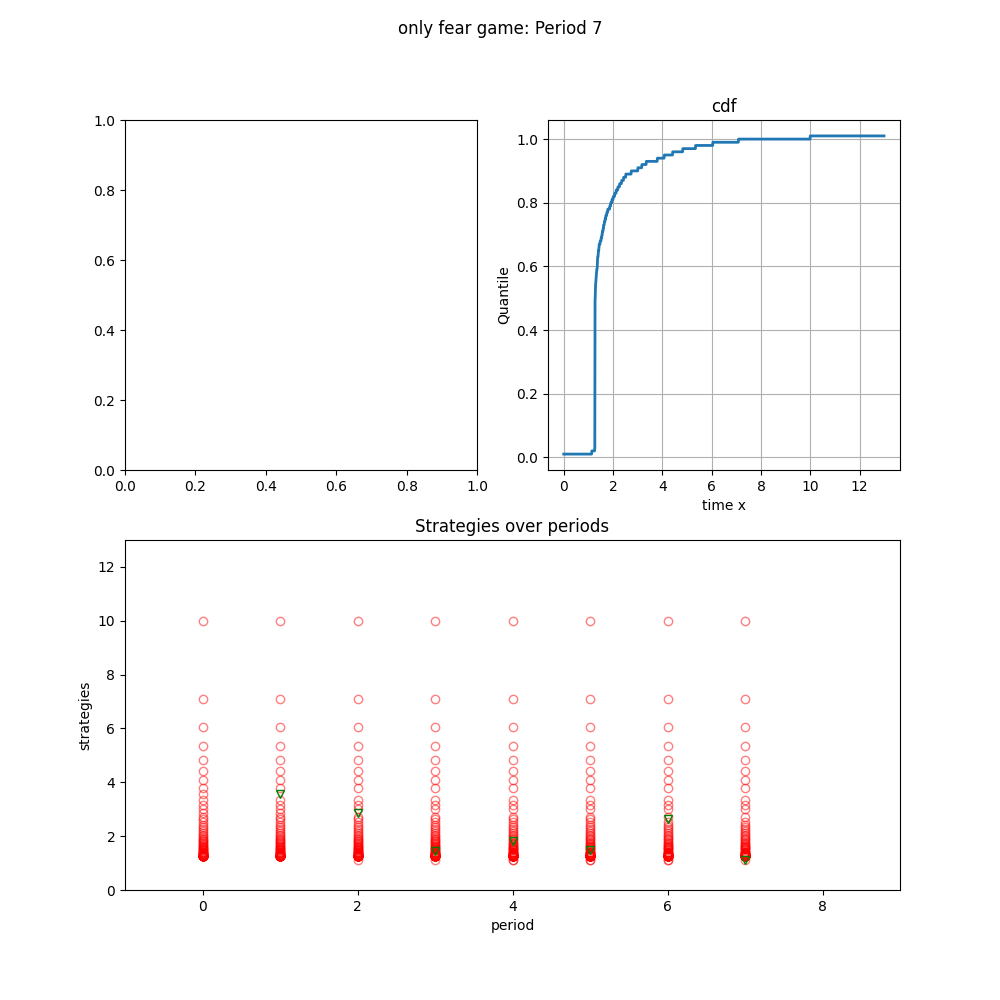

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


KeyError: ('x', 8)

In [3]:
####################################################################################
########## after finishing simulation, run this cell to make graphs ############
############################### 'graphing' cell #################################
####################################################################################

%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt


fig = plt.figure(figsize=(10,10))
gs = fig.add_gridspec(2, 2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, :])
plt.ion()

fig.show()
fig.canvas.draw()

for i in range(round_idx+1):
    ax1.clear()
    ax1.plot(history['x', i], history['y', i], alpha=0.5, linewidth = '2')
    ax1.plot(history['strat_x', i], history['strat_y', i], 'ro', fillstyle='none', alpha=0.7)
#     if history['selected_player_index', i] is not None:
#         ax1.plot(history['strategies', i][history['selected_player_index', i]], 
#              history['strategies_y', i][history['selected_player_index', i]], 'bs', fillstyle='none')
    if (history['selected_player_index', i] is not None) and (i>0):
        ax1.plot(history['strategies', i-1][history['selected_player_index', i]], 
         history['strategies_y', i-1][history['selected_player_index', i]], 'gv', fillstyle='none', label='who gets the chance to move')
#     ax1.set_ylim([0, sim_config['lambda']**2+100])
    ax1.set_xlabel('time x')
    ax1.set_ylabel('Payoff')
    ax1.set_title('payoff')
    ax1.grid()
    ax1.legend()
    
    ax2.clear()
    ax2.plot(history['x', i], history['quantile', i], linewidth = '2')
    ax2.set_xlabel('time x')
    ax2.set_ylabel('Quantile')
    ax2.set_title('cdf')
    ax2.grid()
    
    plot_round = np.array([i]*len(history['strategies', 0]))
    ax3.plot(plot_round, history['strategies', i], 'ro', fillstyle='none', alpha=0.5)
#     if history['selected_player_index', i] is not None:
#         ax3.plot(i, history['strategies', i][history['selected_player_index', i]], 'bs', fillstyle='none')
    if (history['selected_player_index', i] is not None) and (i>0):
        ax3.plot(i, history['strategies', i-1][history['selected_player_index', i]], 'gv', fillstyle='none')
    ax3.set_xlim([-1, round_idx+1])
    ax3.set_ylim([0, sim_config['xmax']])
    ax3.set_xlabel('period')
    ax3.set_ylabel('strategies')
    ax3.set_title('Strategies over periods')
    ax3.grid()

    plt.pause(0.05)
    fig.suptitle(game_type_specification + ' game: Period ' + str(i))
    fig.canvas.draw()
print('Done')

In [5]:
print(history['strategies', 50])

[12.85 12.85 12.85 12.85 12.85 12.85 12.85 12.85 12.85 12.85 12.85 12.85
 12.85 12.85 12.85 12.85 12.85 12.85 12.85 12.85 12.85 12.85 12.85 12.85
 12.85 12.85 12.85 12.85 12.85 12.85 12.85 12.85 12.85 12.85 12.85 12.85
 12.85 12.85 10.77 12.85 12.85 12.85 12.85 12.85 12.85 12.85 12.85 12.85
 12.85 12.85 12.85 12.85 12.85 12.85 12.85 12.81 12.85 12.85 12.85 12.85
 12.85 12.85 12.85 12.85 12.85 12.85 12.85 12.85 12.85 12.85 12.85 12.85
 12.85 12.85 12.85 12.85 12.85 12.85 12.85 12.85 12.85 12.85 12.85 12.85
 12.85 12.85 12.85 12.85 12.85 12.85 12.85 12.85 12.85 12.85 11.43 12.85
 12.85 12.85 12.85 12.85 12.85 12.85 12.85 12.85 12.85 12.85 12.85 12.85
 12.85 12.85 12.85 12.85 12.85 12.85 12.85 12.85 12.85 11.73 12.85 12.85
 12.85 12.85 12.85 12.85 12.85 12.85 12.85 12.85 12.85 12.85 12.85 12.85
 12.85 12.85 12.85 12.85 12.85 12.85 12.85 12.85 12.85 12.85 12.85 12.85
 12.85 12.85 12.85 12.85 12.85 12.85 12.85 12.85 12.85 12.85 11.26 12.85
 11.78 12.85 12.85 12.85 12.85 12.85 12.85 12.85 12

In [6]:
print(history['strategies', 50].max())

13.0
